# Reproducing the Experiment in "Prediction of Pedestrian Speed with Artificial Neural Networks" by Tordeux et al.

In [1]:
# Enable these if automatic reloading of modules is wanted

# Load extension for automatic reload of modules
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import torch
from torch.utils.data import DataLoader
import logging
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import tensorboard
from sklearn.preprocessing import MinMaxScaler

import preprocessing
import plotting
import pedestrian_dataset
import pedestrian_net
from weidmann_method import *

## Tensorboard

Extension for visualizing the training results.
Should only be loaded once, otherwise there is probably an error message.

To start, run `tensorboard --logdir=dir --port 6006` in a terminal or run the following cell.

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6009

## Logging

I used Logging to print messages.
If more messages are welcome, use the logging level `logging.INFO` or even `logging.DEBUG`.
If not, use `logging.WARNING`.

In [4]:
# Set Logging Level
logger_format = '%(levelname)s - %(funcName)s \t%(message)s'
logger_level = logging.WARNING
logging.basicConfig(level=logger_level, format=logger_format)

In [5]:
# Set a torch seed
torch.manual_seed(1234)

## Preprocessing and Loading the Dataset

The different files of data in the format
(`PedID FrameID X Y Z`)
are loaded and converted into the following dictionary format:

`distances` | `speeds`
-|-
Input of our neural network. Array of size $2k+1$ containing the median speed of the $k$ nearest neighbors as the first element and the relative $x$- and $y$-positions of the $k$ nearest neighbors in the following pattern afterwards: $x_1$, $y_1$, $x_2$, $y_2$, ... | Truth value for our neural network. The speed that the pedestrian had in that frame.

To load a list of files, the method `pedestrian_dataset.create_dataset()` is used.
As its first parameter it either takes a list of data files that it should load
or a `pedestrian_dataset.PedestrianDataType` value,
which can be either `BOTTLENECK`, which loads all bottleneck files,
`CORRIDOR`, which loads all corridor files,
or `ALL`, which loads all files.

In [6]:
# Creating datasets with only the smallest corridor scenario with 30 participants
c_015_path = "./Data/Corridor_Data/ug-180-030.txt"
# Note: even when only loading one dataset, it has to be given in a list
c_015_train_val_datasets, c_015_test_dataset = pedestrian_dataset.create_dataset([c_015_path])

# Print the first item from the first train/val dataset part
print(c_015_train_val_datasets[0][0])

{'distances': array([ 296.80893951,   36.1585    ,  -91.69      ,   76.8931    ,
         62.0273    ,   -2.372     ,  201.1667    ,  -21.5438    ,
       -241.436     ,   29.8531    , -262.229     ,   32.8202    ,
        295.624     ,  -18.6053    ,  316.108     ,  -26.2509    ,
        437.719     ,   43.2941    ,  445.954     ,   -0.6295    ,
        559.384     ]), 'speed': 6.112364455756874}


In [7]:
batch_size = 16

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
c_015_temp_train_dataset = torch.utils.data.ConcatDataset(c_015_train_val_datasets[:4])
c_015_temp_val_dataset = c_015_train_val_datasets[4]

c_015_train_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=True)
c_015_val_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=False)

c_015_test_loader = DataLoader(c_015_test_dataset, batch_size=batch_size, drop_last=False)

# # Print the first value given by the train loader
# for item in c_015_train_loader:
#     print(item)
#     break  # break after printing the first item

In [8]:
# Creating datasets with all scenarios loaded
all_train_val_datasets, all_test_dataset = pedestrian_dataset.create_dataset(
    pedestrian_dataset.PedestrianDataType.ALL
)

# Print the first item from the first train/val dataset part
print(all_train_val_datasets[0][0])

{'distances': array([ 83.28914988, -32.428     ,  24.169     ,  37.9846    ,
        38.714     ,  -2.5528    , -57.585     ,   4.0326    ,
        69.008     ,  81.5544    ,   6.506     , -71.6767    ,
       -54.426     ,  49.6994    , -84.303     , -57.71222   ,
        80.09      ,  86.0264    , -55.428     ,  80.5664    ,
        75.733     ]), 'speed': 2.5783409394414765}


In [9]:
batch_size = 10000

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
all_temp_train_dataset = torch.utils.data.ConcatDataset(all_train_val_datasets[:4])
all_temp_val_dataset = all_train_val_datasets[4]

all_train_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=True)
all_val_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=False)

all_test_loader = DataLoader(all_test_dataset, batch_size=batch_size, drop_last=False)

# # Currently Disabled because for batch_size=16 this get's large
# # Print the first value given by the train loader
# for item in all_train_loader:
#     print(item)
#     break  # break after printing the first item

In [10]:
# Create normalized DataLoaders

normalized_train_loader = DataLoader(preprocessing.normalize_data(all_temp_train_dataset), batch_size=batch_size, drop_last=True)
normalized_val_loader = DataLoader(preprocessing.normalize_data(all_temp_val_dataset), batch_size=batch_size, drop_last=True)
normalized_test_loader = DataLoader(preprocessing.normalize_data(all_test_dataset), batch_size=batch_size, drop_last=False)

In [11]:
print(normalized_train_loader)

## Implementing and Training the Model

Now we need to define our model.

@Parim:
I got quite a lot of work done on the model, but there are still TODOs.
I probably won't be able to work more on the practicum this week, but I think everything should be documented well enough to be extended by you.
(I'm using PyTorch Lightning now, which you'll probably remember from I2DL, and the Neural Network is in `pedestrian_net.py`.)

### Model 1 - Weidmann Method Fundamental Diagram

In [12]:
bottleneck_train_val_dataset, bottleneck_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.BOTTLENECK)
corridor_train_val_dataset, corridor_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.CORRIDOR)
all_train_val_dataset, all_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.ALL)

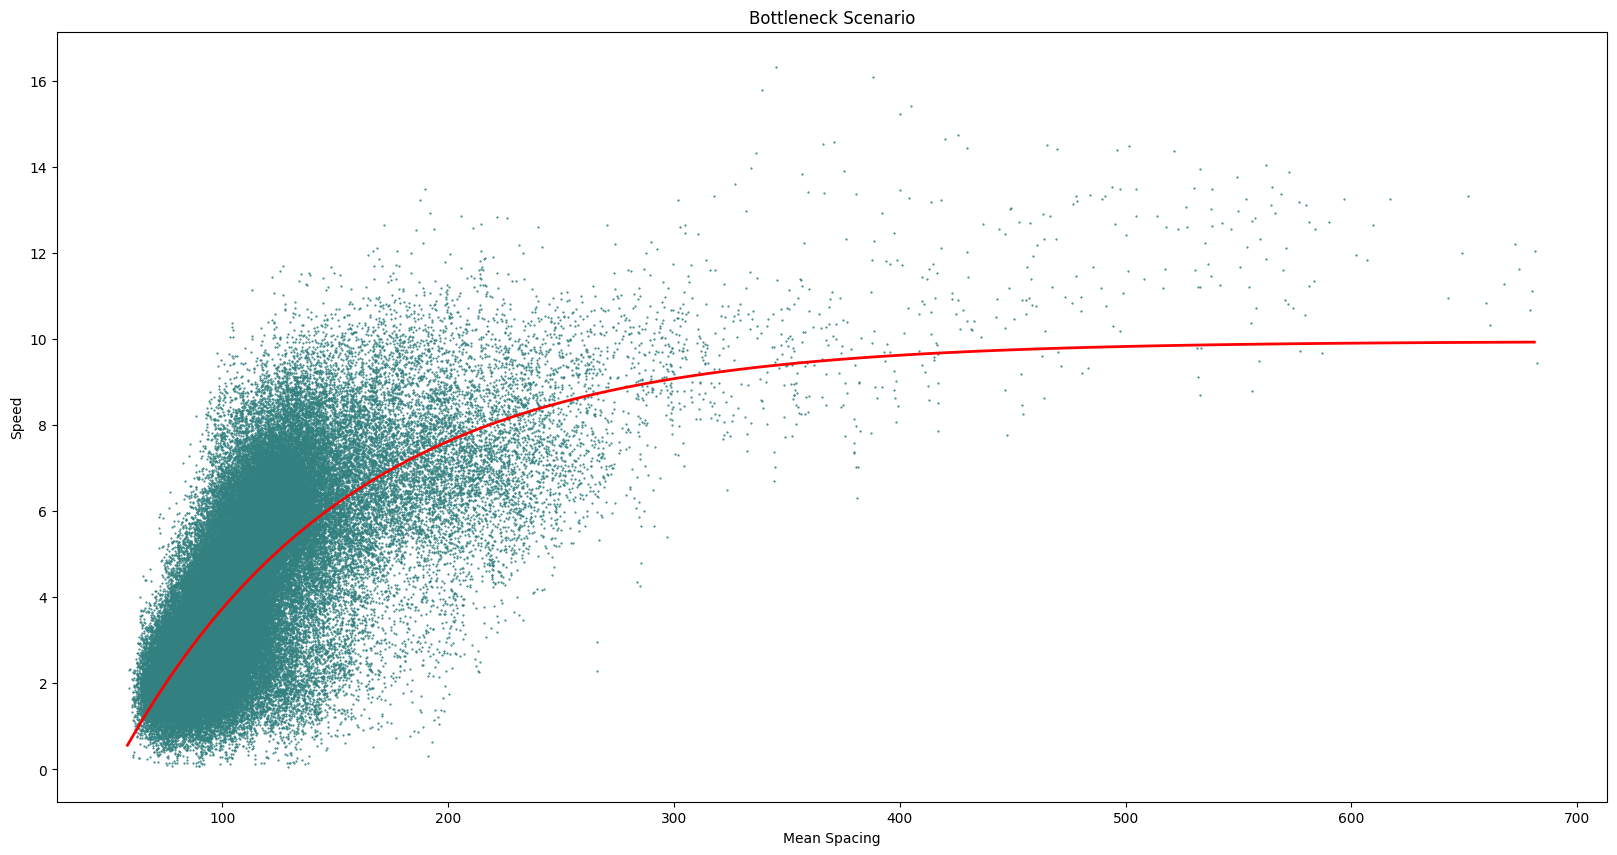

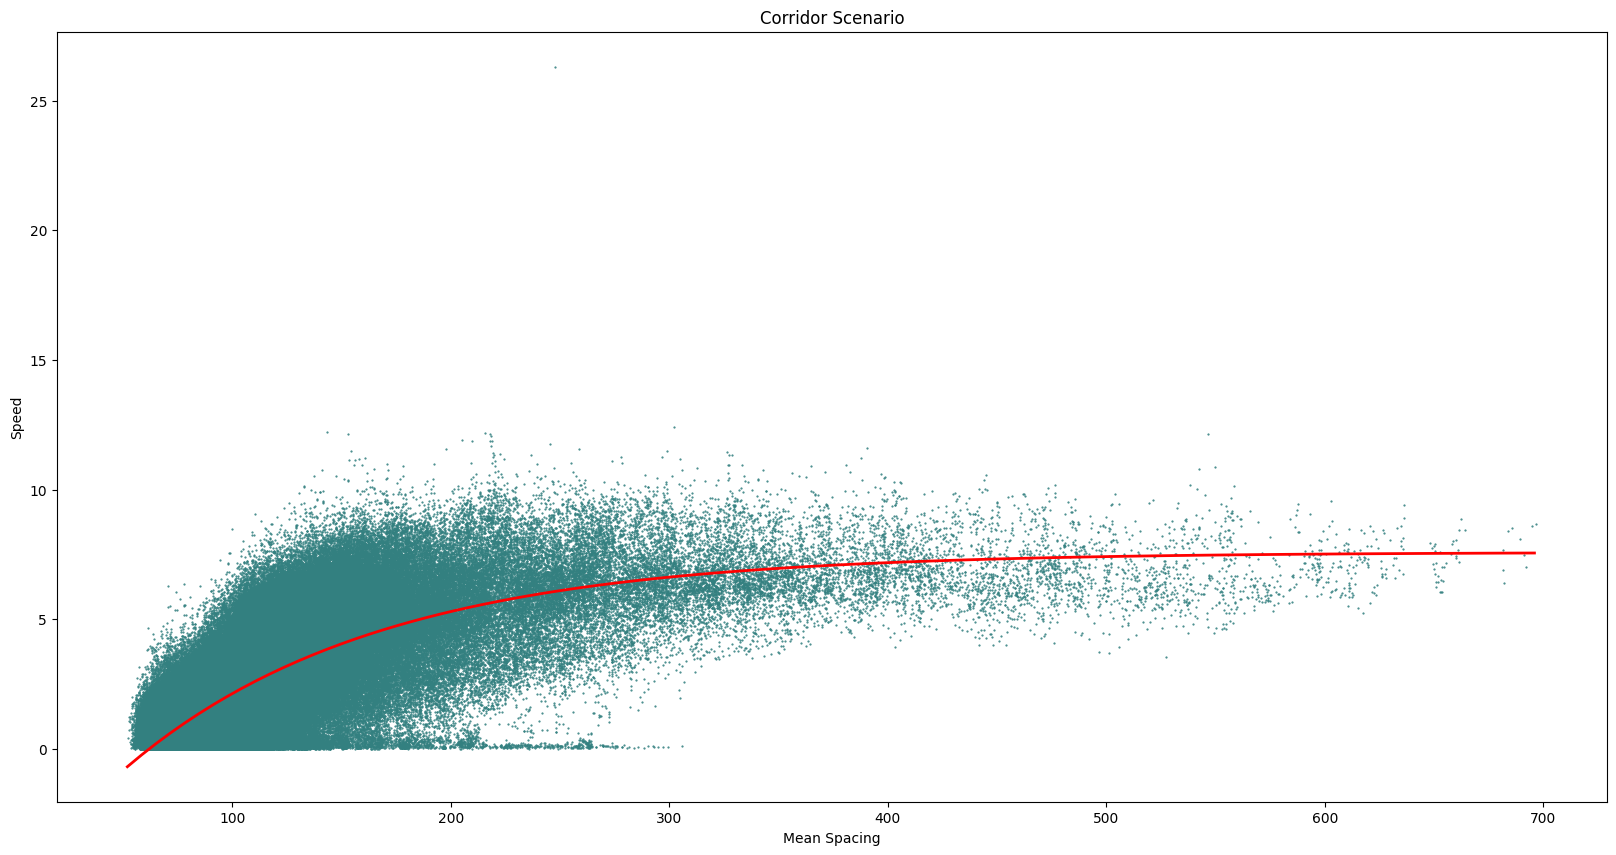

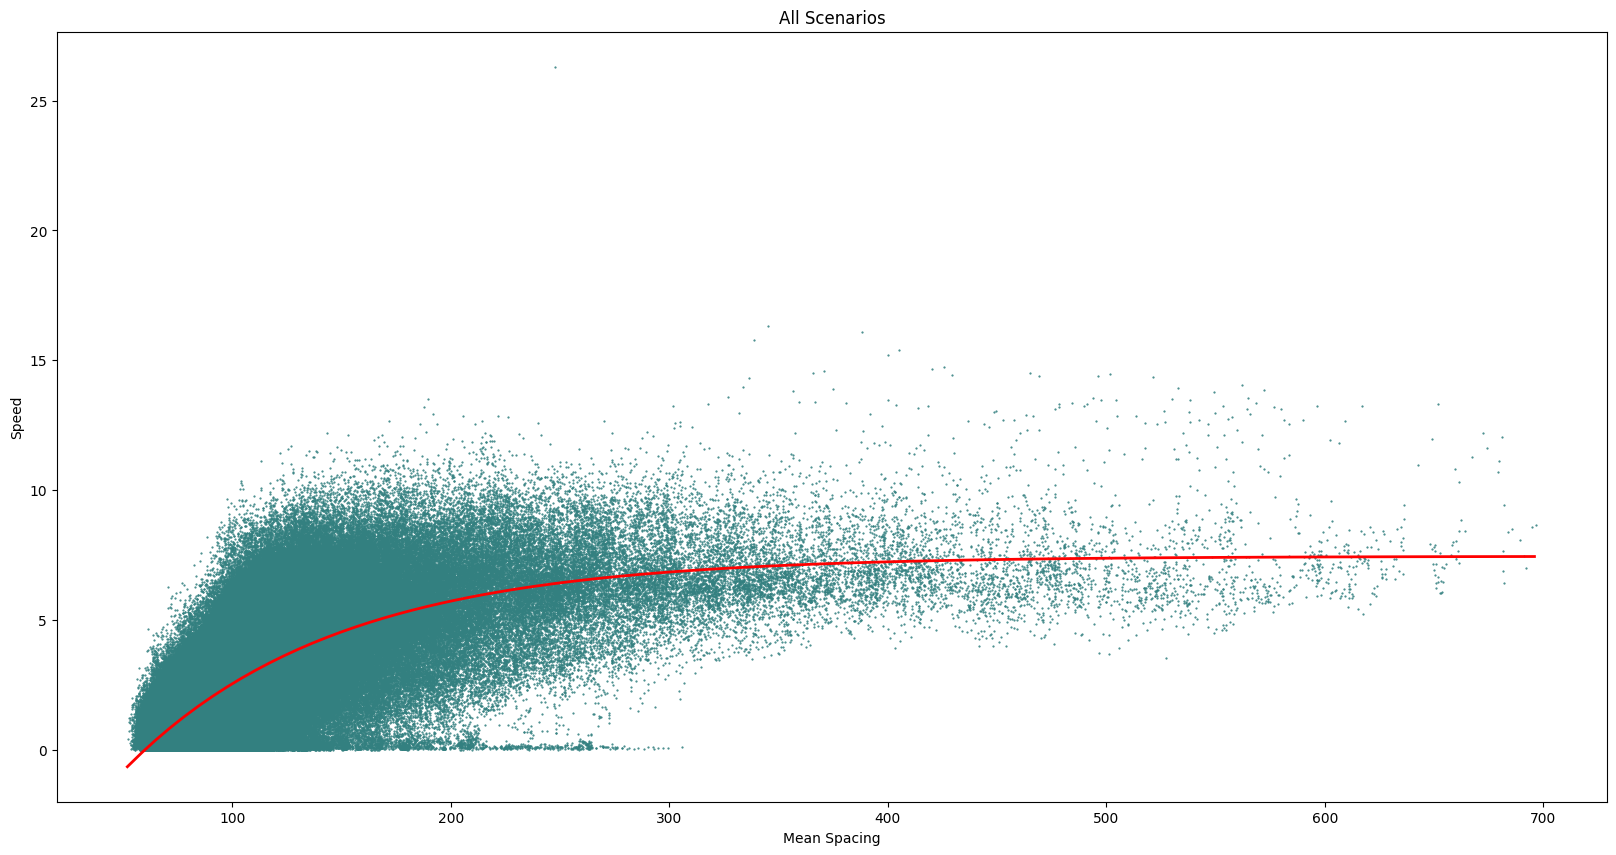

In [13]:
load_dataset = {'Bottleneck Scenario': [bottleneck_train_val_dataset, bottleneck_test_dataset],
                'Corridor Scenario': [corridor_train_val_dataset, corridor_test_dataset ], 
                'All Scenarios': [all_train_val_dataset, all_test_dataset]}
initial_guess = [1, 1, 1]

for i in load_dataset:
    # Prepare the data for the Weidmann method
    train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y = preprocessing.prepare_weidmann_data(load_dataset[i][0], load_dataset[i][1])

    # Use the Weidmann method to fit the data and get the optimized parameters and the mean squared error (mse)
    optimized_parameters, mse, y_fit = use_weidmann_method(train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y, initial_guess=initial_guess)

    # Plot the results
    curve_model = np.linspace(int(min(test_weidmann_x)), int(max(test_weidmann_x)), 100)
    curve_pred = weidmann_equation(curve_model, *optimized_parameters)
    plot_fd_curve(test_weidmann_x, test_weidmann_y, curve_model, curve_pred, title=i)

### Model 2 - Artificial Neural Networks

In [22]:
from sklearn.model_selection import KFold
import numpy as np

# combine all your data into one dataset
dataset = torch.utils.data.ConcatDataset(all_train_val_datasets)


# initialize the KFold class
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):  
    print(f"FOLD {fold}")
    print("--------------------------------")

    # Sample elements randomly from a given list of ids, with replacement.
    train_subsampler = torch.utils.data.sampler.WeightedRandomSampler(torch.ones_like(torch.from_numpy(train_ids)), len(train_ids), replacement=True)

    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10, sampler=train_subsampler,
                      num_workers=8)  
    valloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=val_subsampler,
                      num_workers=8)

    # Init the neural network
    network = pedestrian_net.PedestrianNet(k=k,
                                           hidden_size=hidden_size,
                                           learning_rate=learning_rate,
                                           optimizer=optimizer)
    network.to(device)

    # Initialize a trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices='auto',
        accelerator='cpu',
        callbacks=[early_stop_callback],
        log_every_n_steps=1,
        enable_checkpointing=True
    )

    # Train the network
    trainer.fit(network, trainloader, valloader)

    # Save the current model (checkpoint)
    checkpoint_name = f"./.name/checkpoints/2023-07-05--dataAll-ep100-it001-fold{fold}.ckpt"
    trainer.save_checkpoint(checkpoint_name)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FOLD 0
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Validation DataLoader 0:  13%|█▎        | 709/5335 [00:02<00:17, 265.07it/s]

In [16]:
checkpoint_name = "./.name/checkpoints/2023-07-05--dataAll-ep100-it001.ckpt"

max_epochs = 50
k = 10
hidden_size = 3
learning_rate = 1e-3
optimizer = torch.optim.Adam

In [18]:
# Use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("CPU will be used.")

CPU will be used.


In [20]:
# Choose our dataloaders
# train_loader = all_train_loader
# val_loader   = all_val_loader
# test_loader  = all_test_loader

train_loader = normalized_train_loader
val_loader = normalized_val_loader
test_loader = normalized_test_loader

In [21]:
# define an early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", mode='min', patience=20)

In [18]:
# Define our model
model = pedestrian_net.PedestrianNet(k=k,
                                     hidden_size=hidden_size,
                                     learning_rate=learning_rate,
                                     optimizer=optimizer
                                     )
model.to(device)

PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [20]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    devices='auto',
    accelerator='cpu',
    callbacks=[early_stop_callback],
    log_every_n_steps=1,
    enable_checkpointing=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: /Users/salwetingh/PycharmProjects/crowd-modeling-and-simulation/exercise6/lightning_logs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/salwetingh/PycharmProjects/DataSci/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/salwetingh/PycharmProjects/DataSci/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 42/42 [00:03<00:00, 13.42it/s, v_num=0, train_loss_step=0.0185, val_loss_step=0.0189, val_loss_epoch=0.0162, train_loss_epoch=0.016] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 42/42 [00:03<00:00, 13.40it/s, v_num=0, train_loss_step=0.0185, val_loss_step=0.0189, val_loss_epoch=0.0162, train_loss_epoch=0.016]


In [22]:
print("Done")

Done


In [23]:
trainer.save_checkpoint(checkpoint_name)

## Testing the Model

**After** training and tuning the model, we can test the model.

In [24]:
trainer.test(model, dataloaders=test_loader)

/Users/salwetingh/PycharmProjects/DataSci/.conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 54/54 [00:03<00:00, 15.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010414912766599498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'TEST_LOSS': 0.010414912766599498}]

# TODO

A list of some things that are still to do.
Not a complete list.

- [x] Implement Preprocessing
- [x] Implement Data Preparation
- [x] Implement Model basic structure
- [x] Set up basic training for model
- [ ] Implement cross validation
- [ ] Implement hyper parameter tuning
- [ ] ...
- [ ]

In [ ]:
model(torch.tensor(all_temp_train_dataset[0]['distances']))

In [ ]:
all_temp_train_dataset[0]['speed']